In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from keras import Model, layers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19
from keras.applications import ResNet50V2
from keras.applications import VGG16
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from keras.models import Sequential, load_model

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

**File Structure**

In [ ]:
!apt-get install tree
# create new folders
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
!tree -d

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.8.0-1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
mkdir: cannot create directory ‘TRAIN’: File exists
mkdir: cannot create directory ‘TEST’: File exists
mkdir: cannot create directory ‘VAL’: File exists
mkdir: cannot create directory ‘TRAIN/YES’: File exists
mkdir: cannot create directory ‘TRAIN/NO’: File exists
mkdir: cannot create directory ‘TEST/YES’: File exists
mkdir: cannot create directory ‘TEST/NO’: File exists
mkdir: cannot create directory ‘VAL/YES’: File exists
mkdir: cannot create directory ‘VAL/NO’: File exists
.
├── brain_tumor_dataset
│   ├── no
│   └── yes
├── drive
│   └── MyDrive
│       ├── Colab Notebooks
│       ├── Datasets
│       ├── Important Documents
│       ├── Latest CV + Resume
│       └── Shuuf - COEN 6861
├── sample_data
├── TEST
│   ├── NO
│   └── YES
├── TRAIN
│   ├── NO
│   └── YES
└── VAL
    ├── 

In [ ]:
!unzip /content/drive/MyDrive/Datasets/brain_tumor_dataset.zip

**Data Partition**

In [ ]:
IMG_PATH = '/content/brain_tumor_dataset/'

for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n<5:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n<0.8*IMG_NUM:
                shutil.copy(img, 'TRAIN/' + CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'VAL/' + CLASS.upper() + '/' + FILE_NAME)

**Data Preprocessing**

In [ ]:
#intializing the image size and batch size
height = 244
width = 244
batch_size=16

dataset_dir = '/content/TRAIN/'
test_dir  = '/content/TEST/'

def image_gen(height, width, batch_size=16):
    datagen = ImageDataGenerator(
        rescale=1./255.,
        validation_split=0.2,
    )

    train_ds = datagen.flow_from_directory(
        dataset_dir,
        batch_size=batch_size,
        subset="training",
        color_mode="rgb",
        class_mode='binary',
        shuffle=True,
        target_size=(height, width),
    )
    val_ds = datagen.flow_from_directory(
        dataset_dir,
        batch_size=batch_size,
        subset="validation",
        color_mode="rgb",
        class_mode='binary',
        shuffle=True,
        target_size=(height, width),
    )
    
    test_gen = ImageDataGenerator(
        rescale=1./255.
    )
    test_ds = test_gen.flow_from_directory(
        test_dir,
        batch_size=batch_size,
        shuffle=True,
        color_mode="rgb",
        class_mode="binary",
        target_size=(height, width),
    )

    return train_ds, val_ds, test_ds

def augmented_data(height, width):
    datagen = ImageDataGenerator(
        rescale= 1./255.,
        width_shift_range= 0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        rotation_range=30,
        horizontal_flip=True,
        brightness_range=(0.5, 1.0)
    )
    
    train_ds = datagen.flow_from_directory(
        dataset_dir,
        batch_size=batch_size,
        shuffle=True,
        color_mode="rgb",
        class_mode="binary",
        target_size=(height, width),
    )
    
    return train_ds

train_ds, val_ds, test_ds = image_gen(height, width)

total_images = np.concatenate([train_ds.labels, val_ds.labels, test_ds.labels])
# Print the count of images in each class
print({"No brain tumor cases": len(np.where(total_images == 0)[0]),
       "Brain tumor cases": len(np.where(total_images == 1)[0])})

Found 156 images belonging to 2 classes.
Found 37 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
{'No brain tumor cases': 79, 'Brain tumor cases': 124}


**Data Samples**

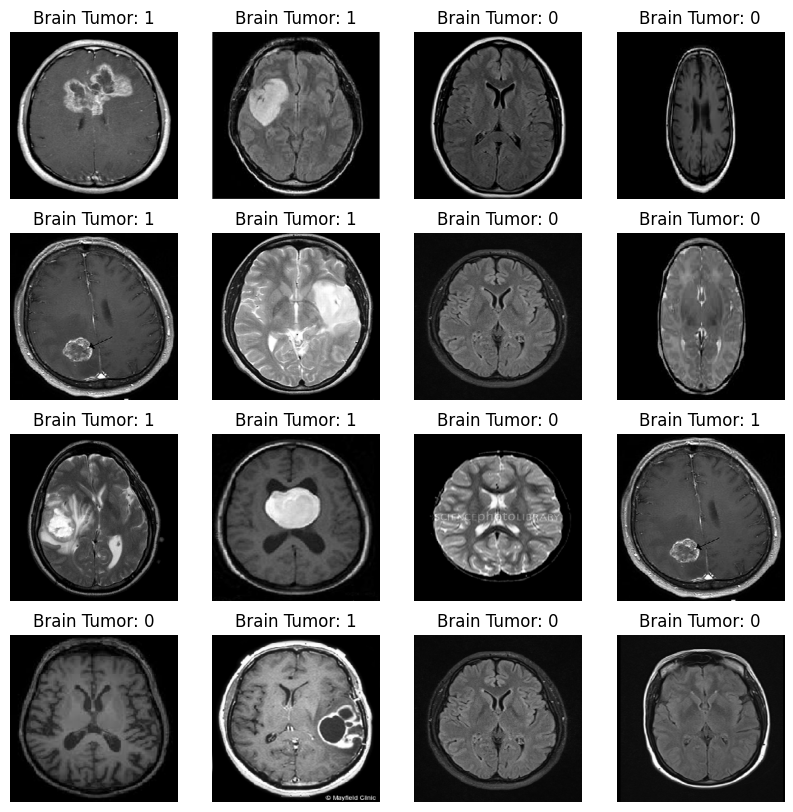

In [ ]:
fig, ax = plt.subplots(4,4, figsize=(10,10))
for k in range(16):
    images, labels = train_ds.next()
    #print(images[0].shape)
    i, j = k//4, k%4
    ax[i, j].imshow(images[0])
    ax[i, j].set_title(f"Brain Tumor: {int(labels[0])}")
    ax[i, j].axis('off')
plt.show()

**Helper Function - Plots Accuracy and Loss Curves**

In [ ]:
def plots(history):
  sns.set_style("darkgrid") #Enabling grid of the graphs

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1,len(accuracy)+1)
  plt.figure(figsize=[12,6])

  plt.subplot(1, 2, 1) #Plotting Training vs Validation Accuracy
  plt.plot(epochs, accuracy, '-', label = 'Training Accuracy')
  plt.plot(epochs, val_accuracy, ':', label = 'Validation Accuracy')
  plt.title('Training Vs Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc = 'lower right')

  plt.subplot(1, 2, 2) #Plotting Training vs Validation Loss
  plt.plot(epochs, loss, '-', label = 'Training Loss')
  plt.plot(epochs, val_loss, ':', label = 'Validation Loss')
  plt.title('Training Vs Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(loc = 'upper right')

  plt.show()

In [ ]:
def confusion_matrix(model, data)
predictions = model.predict(data)
labels = np.where(predictions>0.5,1,0)
cm = confusion_matrix(data.labels, labels)
plt.figure(figsize=(8,8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Tumor','No Tumor'])
disp.plot()
plt.title('Confusion Matrix')
plt.grid(False)
plt.xticks(rotation ='vertical')
plt.show()

**ResNet50V2 - Deep Neural Network**

In [ ]:
base_model = ResNet50V2(input_shape=(244,244,3), include_top=False)
base_model.trainable = False

model1 = Sequential([
    base_model, 
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(256, activation="relu", kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model1.compile(optimizer=Adam(), 
               loss="binary_crossentropy", 
               metrics=['accuracy'])

model1.summary()

checkpoint = tf.keras.callbacks.ModelCheckpoint('resnet50v2_best.h5', 
                                                monitor='accuracy', verbose=1, 
                                                mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="accuracy", mode="max", restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

history1 = model1.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=callbacks_list)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                        

In [ ]:
model = load_model('resnet50v2_best.h5')
model.evaluate(train_ds)
model.evaluate(val_ds)
model.evaluate(test_ds)

1/1 [==============================] - 2s 2s/step - loss: 0.2301 - accuracy: 0.9000


[0.23011629283428192, 0.8999999761581421]

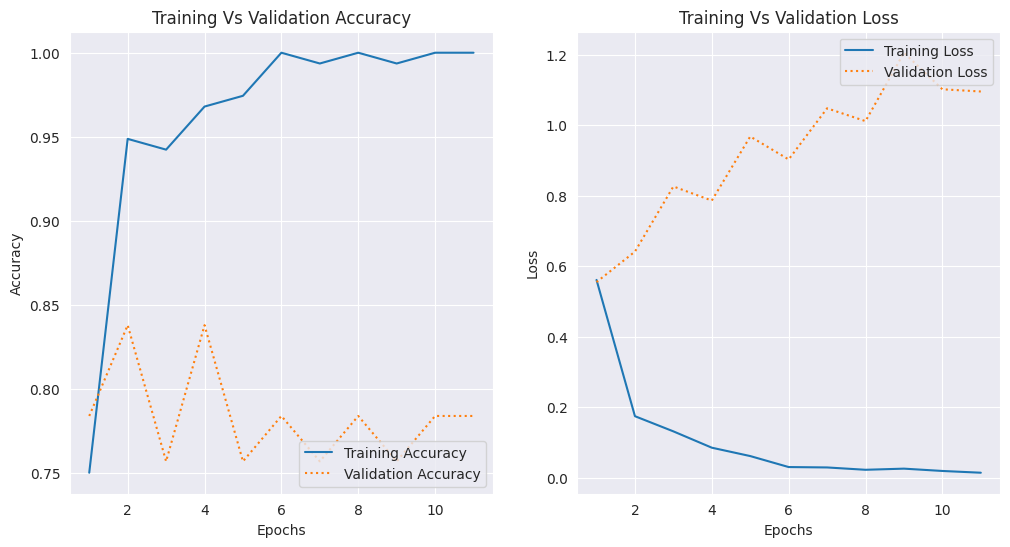

In [ ]:
plots(history1)

1/1 [==============================] - 3s 3s/step


<Figure size 800x800 with 0 Axes>

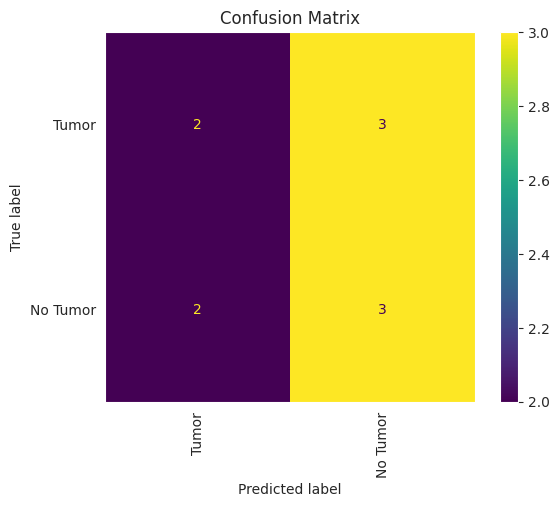

In [ ]:
predictions = model.predict(test_ds)
labels = np.where(predictions>0.5,1,0)
cm = confusion_matrix(test_ds.labels, labels)
plt.figure(figsize=(8,8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Tumor','No Tumor'])
disp.plot()
plt.title('Confusion Matrix')
plt.grid(False)
plt.xticks(rotation ='vertical')
plt.show()

**ResNet50V2 - Deep Neural Network with Augmented Data**

In [ ]:
aug_train_ds = augmented_data(244, 244)
checkpoint = tf.keras.callbacks.ModelCheckpoint('resnet50v2aug_best.h5', 
                                                monitor='accuracy', verbose=1, 
                                                mode='max',save_best_only=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.3, patience=4, min_lr=0.0000001)
callbacks_list = [checkpoint,early,reduce_lr]

history2 = model1.fit(aug_train_ds, validation_data=val_ds, epochs=30, callbacks=callbacks_list)

Found 193 images belonging to 2 classes.
Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.4693 - accuracy: 0.8342
Epoch 1: val_accuracy improved from -inf to 0.81081, saving model to resnet50v2aug_best.h5
13/13 [==============================] - 57s 4s/step - loss: 0.4693 - accuracy: 0.8342 - val_loss: 0.5165 - val_accuracy: 0.8108 - lr: 0.0010
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.3340 - accuracy: 0.8601
Epoch 2: val_accuracy did not improve from 0.81081
13/13 [==============================] - 56s 4s/step - loss: 0.3340 - accuracy: 0.8601 - val_loss: 0.6754 - val_accuracy: 0.7568 - lr: 0.0010
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.3348 - accuracy: 0.8549
Epoch 3: val_accuracy improved from 0.81081 to 0.83784, saving model to resnet50v2aug_best.h5
13/13 [==============================] - 56s 4s/step - loss: 0.3348 - accuracy: 0.8549 - val_loss: 0.4025 - val_accuracy: 0.8378 - lr: 0.0010
Epoch 4/30
13/1

In [ ]:
model = load_model('resnet50v2aug_best.h5')
model.evaluate(aug_train_ds)
model.evaluate(val_ds)
model.evaluate(test_ds)

1/1 [==============================] - 3s 3s/step - loss: 0.1222 - accuracy: 0.9000


[0.12218435108661652, 0.8999999761581421]

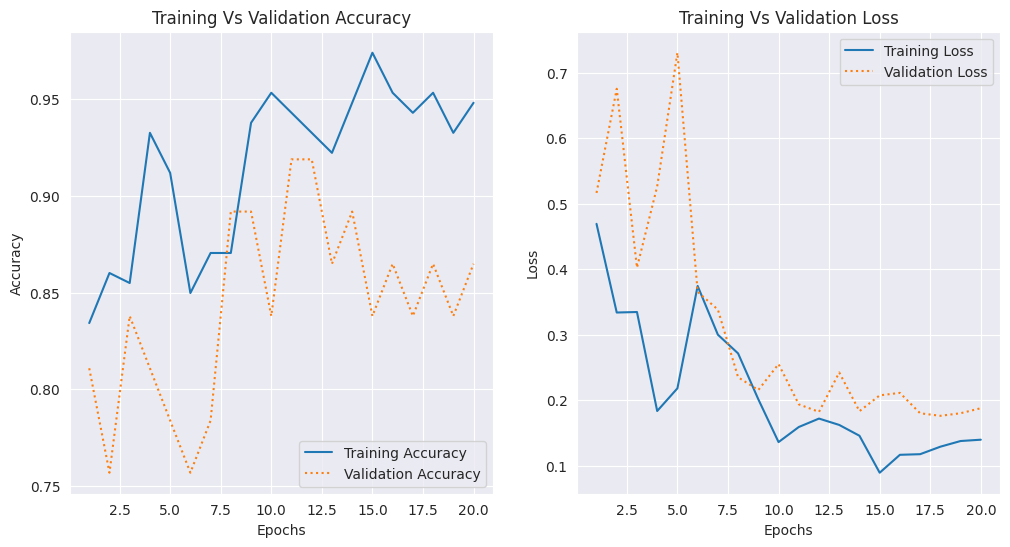

In [ ]:
plots(history2)

1/1 [==============================] - 3s 3s/step


<Figure size 800x800 with 0 Axes>

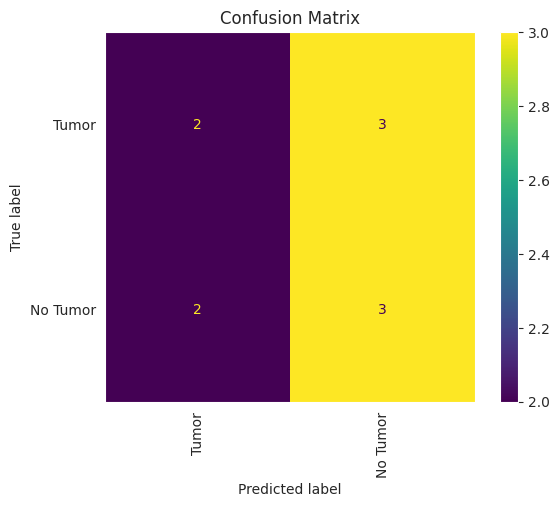

In [ ]:
predictions = model.predict(test_ds)
labels = np.where(predictions>0.5,1,0)
cm = confusion_matrix(test_ds.labels, labels)
plt.figure(figsize=(8,8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Tumor','No Tumor'])
disp.plot()
plt.title('Confusion Matrix')
plt.grid(False)
plt.xticks(rotation ='vertical')
plt.show()

**VGG19 - Deep Neural Network**

In [ ]:
tf.keras.backend.clear_session()

#initializing new height and width for images
train_ds, val_ds, test_ds = image_gen(224, 224)

base_model = VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False

model2 = Sequential()
model2.add(base_model)
model2.add(Flatten())
model2.add(Dropout(0.5))
model2.add(Dense(1,activation='sigmoid'))

model2.compile(optimizer=Adam(), 
               loss="binary_crossentropy", 
               metrics=['accuracy'])
model2.summary()

checkpoint = tf.keras.callbacks.ModelCheckpoint('vgg19_best.h5', 
                                                monitor='accuracy', verbose=1, 
                                                mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="accuracy", mode="max", restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

history3 = model2.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=callbacks_list)

Found 156 images belonging to 2 classes.
Found 37 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________
Epoch 1/30
10/10 [==============================] 

In [ ]:
model = load_model('vgg19_best.h5')
model.evaluate(train_ds)
model.evaluate(val_ds)
model.evaluate(test_ds)

1/1 [==============================] - 9s 9s/step - loss: 0.5839 - accuracy: 0.8000


[0.5839383006095886, 0.800000011920929]

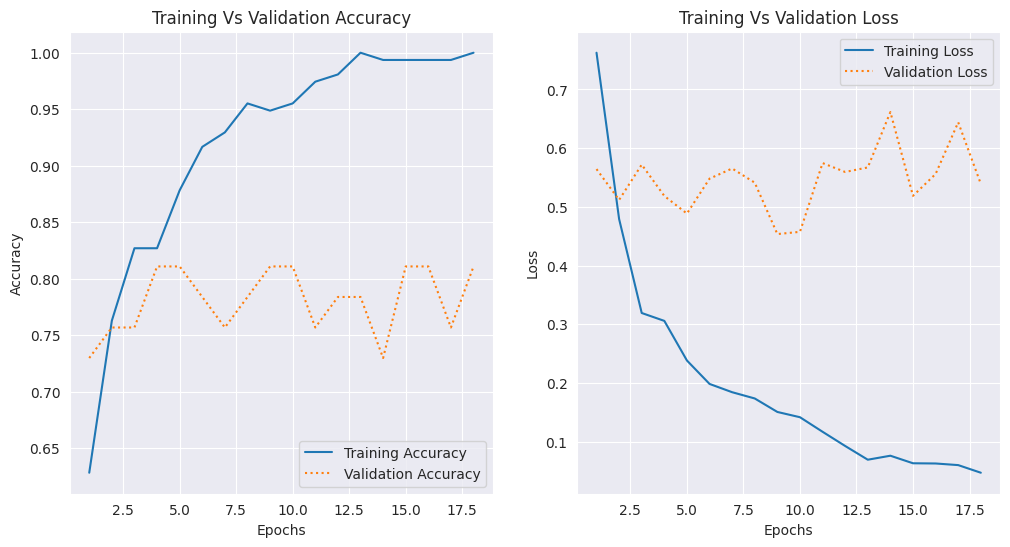

In [ ]:
plots(history3)

1/1 [==============================] - 7s 7s/step


<Figure size 800x800 with 0 Axes>

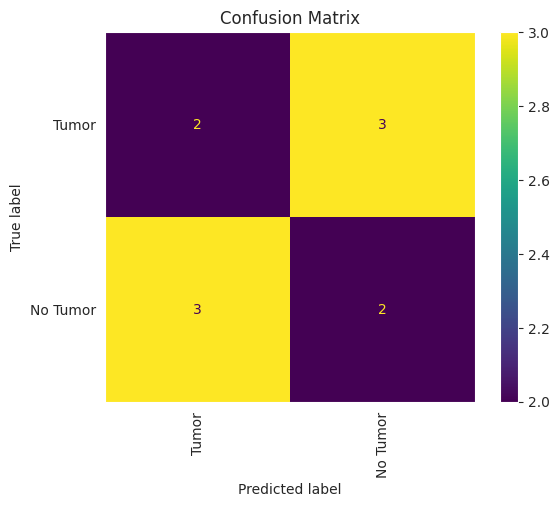

In [ ]:
predictions = model.predict(test_ds)
labels = np.where(predictions>0.5,1,0)
cm = confusion_matrix(test_ds.labels, labels)
plt.figure(figsize=(8,8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Tumor','No Tumor'])
disp.plot()
plt.title('Confusion Matrix')
plt.grid(False)
plt.xticks(rotation ='vertical')
plt.show()


**VGG19 - Deep Neural Network with Augmented Data**

In [ ]:
aug_train_ds = augmented_data(224, 224)
checkpoint = tf.keras.callbacks.ModelCheckpoint('vgg19_aug.h5', 
                                                monitor='accuracy', verbose=1, 
                                                mode='max',save_best_only=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.3, patience=3, min_lr=0.0000001)
callbacks_list = [checkpoint,early,reduce_lr]

history4 = model2.fit(aug_train_ds, validation_data=val_ds, epochs=15, callbacks=callbacks_list)

Found 193 images belonging to 2 classes.
Epoch 1/15
13/13 [==============================] - ETA: 0s - loss: 0.4637 - accuracy: 0.8238 
Epoch 1: accuracy improved from -inf to 0.82383, saving model to vgg19_aug.h5
13/13 [==============================] - 188s 15s/step - loss: 0.4637 - accuracy: 0.8238 - val_loss: 0.6084 - val_accuracy: 0.7297 - lr: 0.0010
Epoch 2/15
13/13 [==============================] - ETA: 0s - loss: 0.4660 - accuracy: 0.7927 
Epoch 2: accuracy did not improve from 0.82383
13/13 [==============================] - 200s 16s/step - loss: 0.4660 - accuracy: 0.7927 - val_loss: 0.4687 - val_accuracy: 0.8108 - lr: 0.0010
Epoch 3/15
13/13 [==============================] - ETA: 0s - loss: 0.7562 - accuracy: 0.7461 
Epoch 3: accuracy did not improve from 0.82383
13/13 [==============================] - 201s 16s/step - loss: 0.7562 - accuracy: 0.7461 - val_loss: 0.6325 - val_accuracy: 0.7568 - lr: 0.0010
Epoch 4/15
13/13 [==============================] - ETA: 0s - loss: 0.

In [ ]:
model = load_model('vgg19_aug.h5')
model.evaluate(aug_train_ds)
model.evaluate(val_ds)
model.evaluate(test_ds)

1/1 [==============================] - 7s 7s/step - loss: 0.7549 - accuracy: 0.8000


[0.7549390196800232, 0.800000011920929]

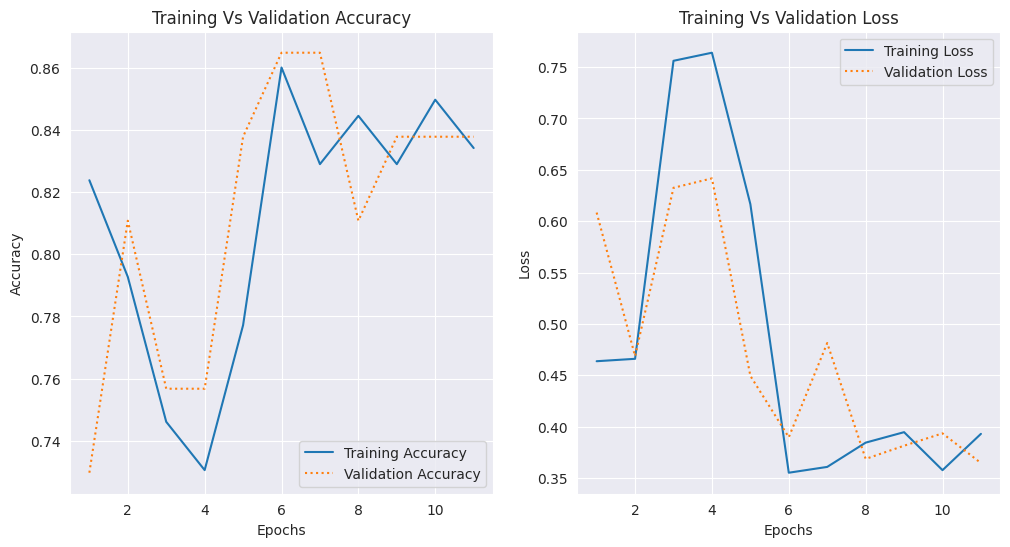

In [ ]:
plots(history4)

1/1 [==============================] - 9s 9s/step


<Figure size 800x800 with 0 Axes>

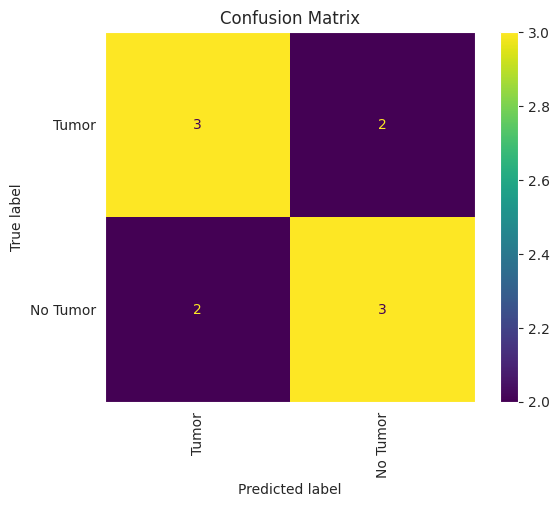

In [ ]:
predictions = model.predict(test_ds)
labels = np.where(predictions>0.5,1,0)
cm = confusion_matrix(test_ds.labels, labels)
plt.figure(figsize=(8,8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Tumor','No Tumor'])
disp.plot()
plt.title('Confusion Matrix')
plt.grid(False)
plt.xticks(rotation ='vertical')
plt.show()

**VGG16 - Deep Neural Network**

In [ ]:
tf.keras.backend.clear_session()

base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False

model3 = keras.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')
])

model3.summary()

model3.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(0.001), metrics=['accuracy'])

checkpoint = tf.keras.callbacks.ModelCheckpoint('vgg16_best.h5', 
                                                monitor='accuracy', verbose=1, 
                                                mode='max',save_best_only=True)

early = tf.keras.callbacks.EarlyStopping(monitor="accuracy", mode="max", restore_best_weights=True, patience=3)

callbacks_list = [checkpoint,early]

history6 = model3.fit(train_ds, 
           validation_data=val_ds,
           epochs=15,
           shuffle=True,
           verbose=True,
           callbacks=callbacks_list
          )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/15
10/10 [==============================] - ETA: 0s - loss: 0.7653 - accuracy: 0.6026 
Epoch 1: accuracy improved from -inf to 0.60256, saving model to vgg16_best.h5
10/10 [==============================] - 162s 15s/step - loss: 0.7653 - accuracy: 0.6026 - val_loss: 0.7974 - val_accuracy: 0.648

In [ ]:
model = load_model('vgg16_best.h5')
model.evaluate(train_ds)
model.evaluate(val_ds)
model.evaluate(test_ds)

1/1 [==============================] - 7s 7s/step - loss: 0.4695 - accuracy: 0.8000


[0.4694918990135193, 0.800000011920929]

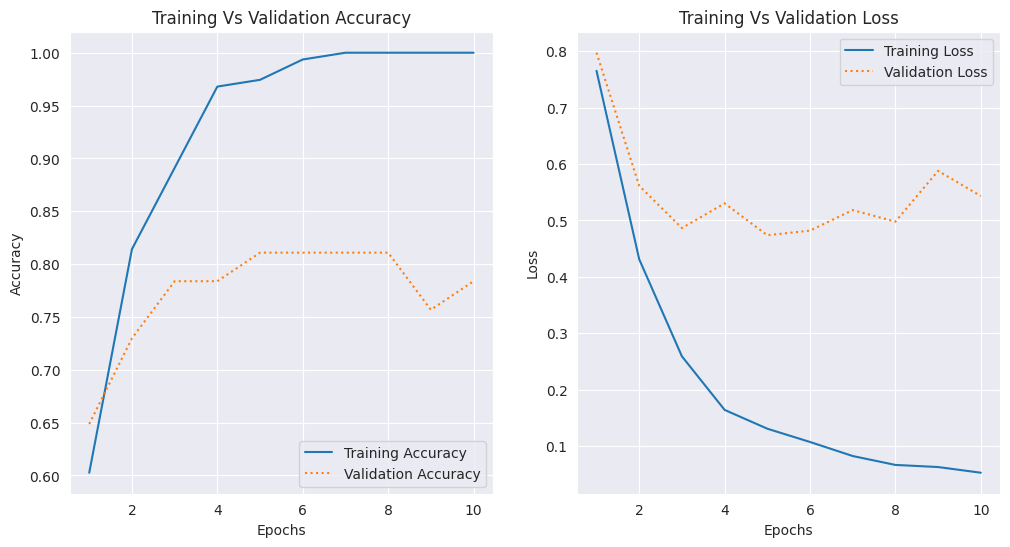

In [ ]:
plots(history6)

1/1 [==============================] - 6s 6s/step


<Figure size 800x800 with 0 Axes>

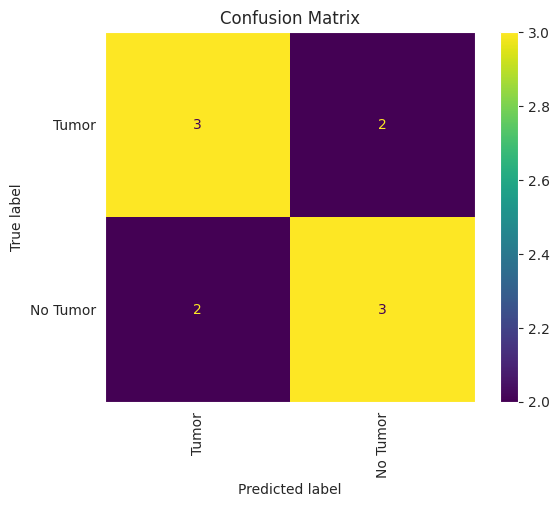

In [ ]:
predictions = model.predict(test_ds)
labels = np.where(predictions>0.5,1,0)
cm = confusion_matrix(test_ds.labels, labels)
plt.figure(figsize=(8,8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Tumor','No Tumor'])
disp.plot()
plt.title('Confusion Matrix')
plt.grid(False)
plt.xticks(rotation ='vertical')
plt.show()

**VGG16 - Deep Neural Network with Augmented Data**

In [ ]:
aug_train_ds = augmented_data(224, 224)
checkpoint = tf.keras.callbacks.ModelCheckpoint('vgg16_aug.h5', 
                                                monitor='accuracy', verbose=1, 
                                                mode='max',save_best_only=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.3, patience=3, min_lr=0.0000001)
callbacks_list = [checkpoint,early,reduce_lr]

history7 = model3.fit(aug_train_ds, validation_data=val_ds, epochs=15, callbacks=callbacks_list)

Found 193 images belonging to 2 classes.
Epoch 1/15
13/13 [==============================] - ETA: 0s - loss: 0.4596 - accuracy: 0.7927
Epoch 1: accuracy improved from -inf to 0.79275, saving model to vgg16_aug.h5
13/13 [==============================] - 172s 13s/step - loss: 0.4596 - accuracy: 0.7927 - val_loss: 0.4759 - val_accuracy: 0.8378 - lr: 0.0010
Epoch 2/15
13/13 [==============================] - ETA: 0s - loss: 0.4822 - accuracy: 0.7617
Epoch 2: accuracy did not improve from 0.79275
13/13 [==============================] - 168s 13s/step - loss: 0.4822 - accuracy: 0.7617 - val_loss: 0.5371 - val_accuracy: 0.8108 - lr: 0.0010
Epoch 3/15
13/13 [==============================] - ETA: 0s - loss: 0.3662 - accuracy: 0.8135
Epoch 3: accuracy improved from 0.79275 to 0.81347, saving model to vgg16_aug.h5
13/13 [==============================] - 170s 13s/step - loss: 0.3662 - accuracy: 0.8135 - val_loss: 0.3981 - val_accuracy: 0.8919 - lr: 0.0010
Epoch 4/15
13/13 [=====================

In [ ]:
model = load_model('vgg16_aug.h5')
model.evaluate(train_ds)
model.evaluate(val_ds)
model.evaluate(test_ds)

1/1 [==============================] - 5s 5s/step - loss: 0.5182 - accuracy: 0.8000


[0.5182331204414368, 0.800000011920929]

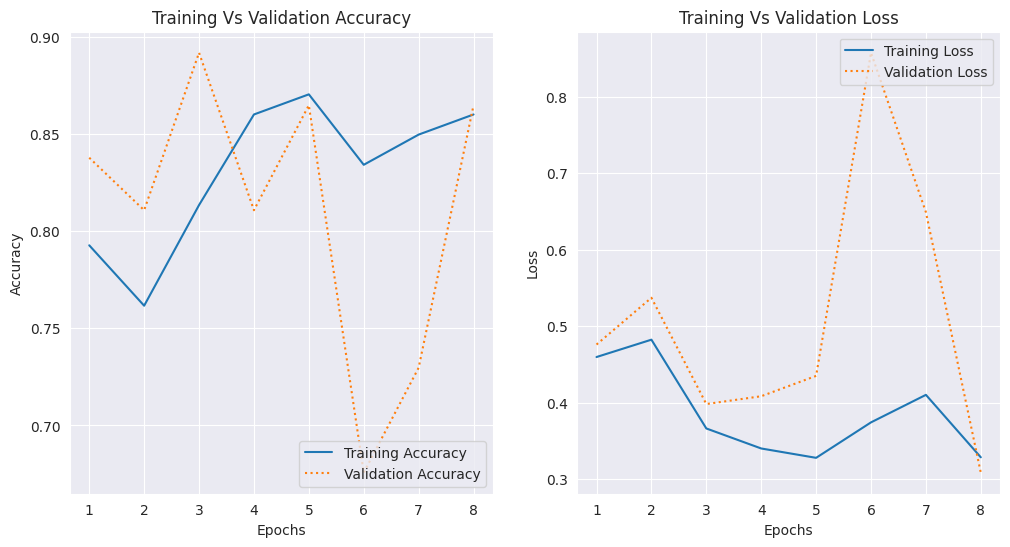

In [ ]:
plots(history7)

1/1 [==============================] - 7s 7s/step


<Figure size 800x800 with 0 Axes>

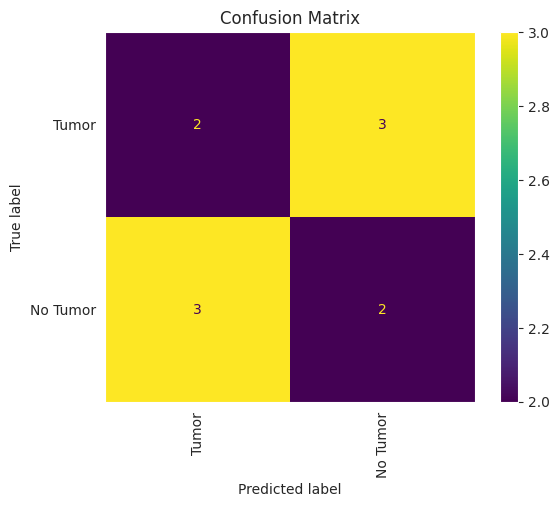

In [ ]:
predictions = model.predict(test_ds)
labels = np.where(predictions>0.5,1,0)
cm = confusion_matrix(test_ds.labels, labels)
plt.figure(figsize=(8,8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Tumor','No Tumor'])
disp.plot()
plt.title('Confusion Matrix')
plt.grid(False)
plt.xticks(rotation ='vertical')
plt.show()

**End of File**